## Connect To Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# root = "drive/MyDrive/ANNSSM/codes/Datasets"
root = "drive/MyDrive/CMP/Datasets"

## Importing Packages

In [3]:
import numpy as np
import pickle
import csv
from tqdm import tqdm
import pandas as pd
import tensorflow as tf

## Data Preparation

#### Load SUBTLEX data

In [4]:
# Loading subtlex data
SUBTLEX_df = pd.read_excel(root + '/SUBTLEX_Zipf.xlsx')

# renaming columns for latter merge use and dropping unneccery columns
SUBTLEX_df.rename(columns={'Word':'string', 'Zipf-value': 'zipf'}, inplace=True)
SUBTLEX_df.drop(SUBTLEX_df.columns[1:-1], axis=1, inplace=True)
SUBTLEX_df.head()

,string,zipf
0,a,7.309360
1,aa,3.236317
2,aaa,2.706807
3,aah,4.721425
4,aahed,1.592864


In [5]:
def categorise_by_zipf(row):
    """
    categorizing data string as High frequency word (HF),
    Low frequency word (LF) and non-word (NW) by zipf value

    Parameters
    ----------
        row: pandas series
            pandas dataframe's row containing label and zipf column
    
    Returns:
        category (str): HF, LF, NW
    """
    category = ''
    if row['label'] == 0:
        category = 'NW'
    elif row['label'] == 1 and row['zipf'] > 3:
        category = 'HF'
    else:
        category = 'LF'
    return category

# Load ELP data and Merge with Subtlex data

Reading **words** and **non-words** datasets



In [6]:
words = []
with open(root+"/Items.csv", 'r') as file:
    reader = csv.reader(file)
    for index, row in enumerate(tqdm(reader)):
        if index == 0:
            continue
        words.append([row[0], row[2].replace(',', ''), 'word'])


nonwords = []
with open(root+"/nonword.csv", 'r') as file:
    reader = csv.reader(file)
    for index, row in enumerate(tqdm(reader)):
        if index == 0:
            continue
        nonwords.append([row[0], 'nonword'])


40483it [00:01, 32497.10it/s]
40342it [00:01, 32802.86it/s]


Adding appropriate encodings for extra information for both words and non-words

In [7]:
for w in words:
    w.insert(3, [1, 0])
    w.insert(4, 1)

for nw in nonwords:
    nw.insert(1, 0)
    nw.insert(3, [0, 1])
    nw.insert(4, 0)

In [8]:
data_df = pd.DataFrame(words + nonwords,
               columns =['string', 'freq', 'type', 'code', 'label'])

In [9]:
data_df

,string,freq,type,code,label
0,a,10610626,word,"[1, 0]",1
1,aah,222,word,"[1, 0]",1
2,Aaron,10806,word,"[1, 0]",1
3,aback,387,word,"[1, 0]",1
4,abacus,513,word,"[1, 0]",1
...,...,...,...,...,...
80818,declassificarion,0,nonword,"[0, 1]",0
80819,antifundamentadast,0,nonword,"[0, 1]",0
80820,transcontanental,0,nonword,"[0, 1]",0
80821,iv,0,nonword,"[0, 1]",0


Loading elp data and merging them with subtlex data

In [10]:
# loading elp words and non-words as seprate dataframes
elp_words = pd.DataFrame(words, columns =['string', 'freq', 'represention', 'code', 'label'])
elp_nonwords = pd.DataFrame(nonwords, columns =['string', 'freq', 'represention', 'code', 'label'])

# mergeing elp words with subtlex words to get zipf for each elp words
# elp words that does not have zipf will be droped
elp_words = pd.merge(elp_words, SUBTLEX_df, on='string', how='left').dropna()
elp_df = pd.concat([elp_words, elp_nonwords])

# 
elp_df.fillna(0, inplace=True)
elp_df['category'] = elp_df.apply(lambda row: categorise_by_zipf(row), axis=1)
elp_df.drop_duplicates(subset=['string'], inplace=True)

In [11]:
elp_df = elp_df.sample(frac=1.0)
elp_df.head()

,string,freq,represention,code,label,zipf,category
17999,incidents,4573,word,"[1, 0]",1,3.425373,HF
32955,tomersault,0,nonword,"[0, 1]",0,0.000000,NW
12118,elters,0,nonword,"[0, 1]",0,0.000000,NW
32692,knapped,0,nonword,"[0, 1]",0,0.000000,NW
22533,tooch,0,nonword,"[0, 1]",0,0.000000,NW


Splitting train and test datasets

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(elp_df['string'],elp_df['label'], stratify=elp_df['label'], test_size=.2)

In [13]:
y_train

22175    0
16808    1
38884    1
17836    0
14859    0
        ..
11262    0
9371     0
9964     1
25414    0
33192    0
Name: label, Length: 59453, dtype: int64

Add encodings for train and test outputs representing the correct labels of each entry in the dataset

In [14]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_train

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [15]:
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)
y_test

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

## Building the Model

In [16]:
!pip install "tensorflow-text==2.8.*"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 27.1 MB/s 


In [17]:
import tensorflow_hub as hub
import tensorflow_text as text

In [18]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessing_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name='preprocessing', trainable=False)

encoder_inputs = preprocessing_layer(text_input)
#version1: small bert
# encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1", name='BERT_encoder', trainable=False)

#version2: bert_en_uncased_L-12_H-768_A-12
encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3", name='BERT_encoder', trainable=False)

outputs = encoder(encoder_inputs)

# Neural network layers
net = outputs['pooled_output']
net = tf.keras.layers.Dropout(0.1)(net)
net = tf.keras.layers.Dense(300, activation="relu", name="dense1")(net)
net = tf.keras.layers.Dense(300, activation="relu", name="dense2")(net)
net = tf.keras.layers.Dropout(0.5)(net)
net = tf.keras.layers.Dense(100, activation="relu", name="dense3")(net)
net = tf.keras.layers.Dense(50, activation="relu", name="dense4")(net)
net = tf.keras.layers.Dropout(0.25)(net)
net = tf.keras.layers.Dense(10, activation="relu", name="dense5")(net)
net = tf.keras.layers.Dense(2, activation='softmax', name='classifier')(net)
# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [net])

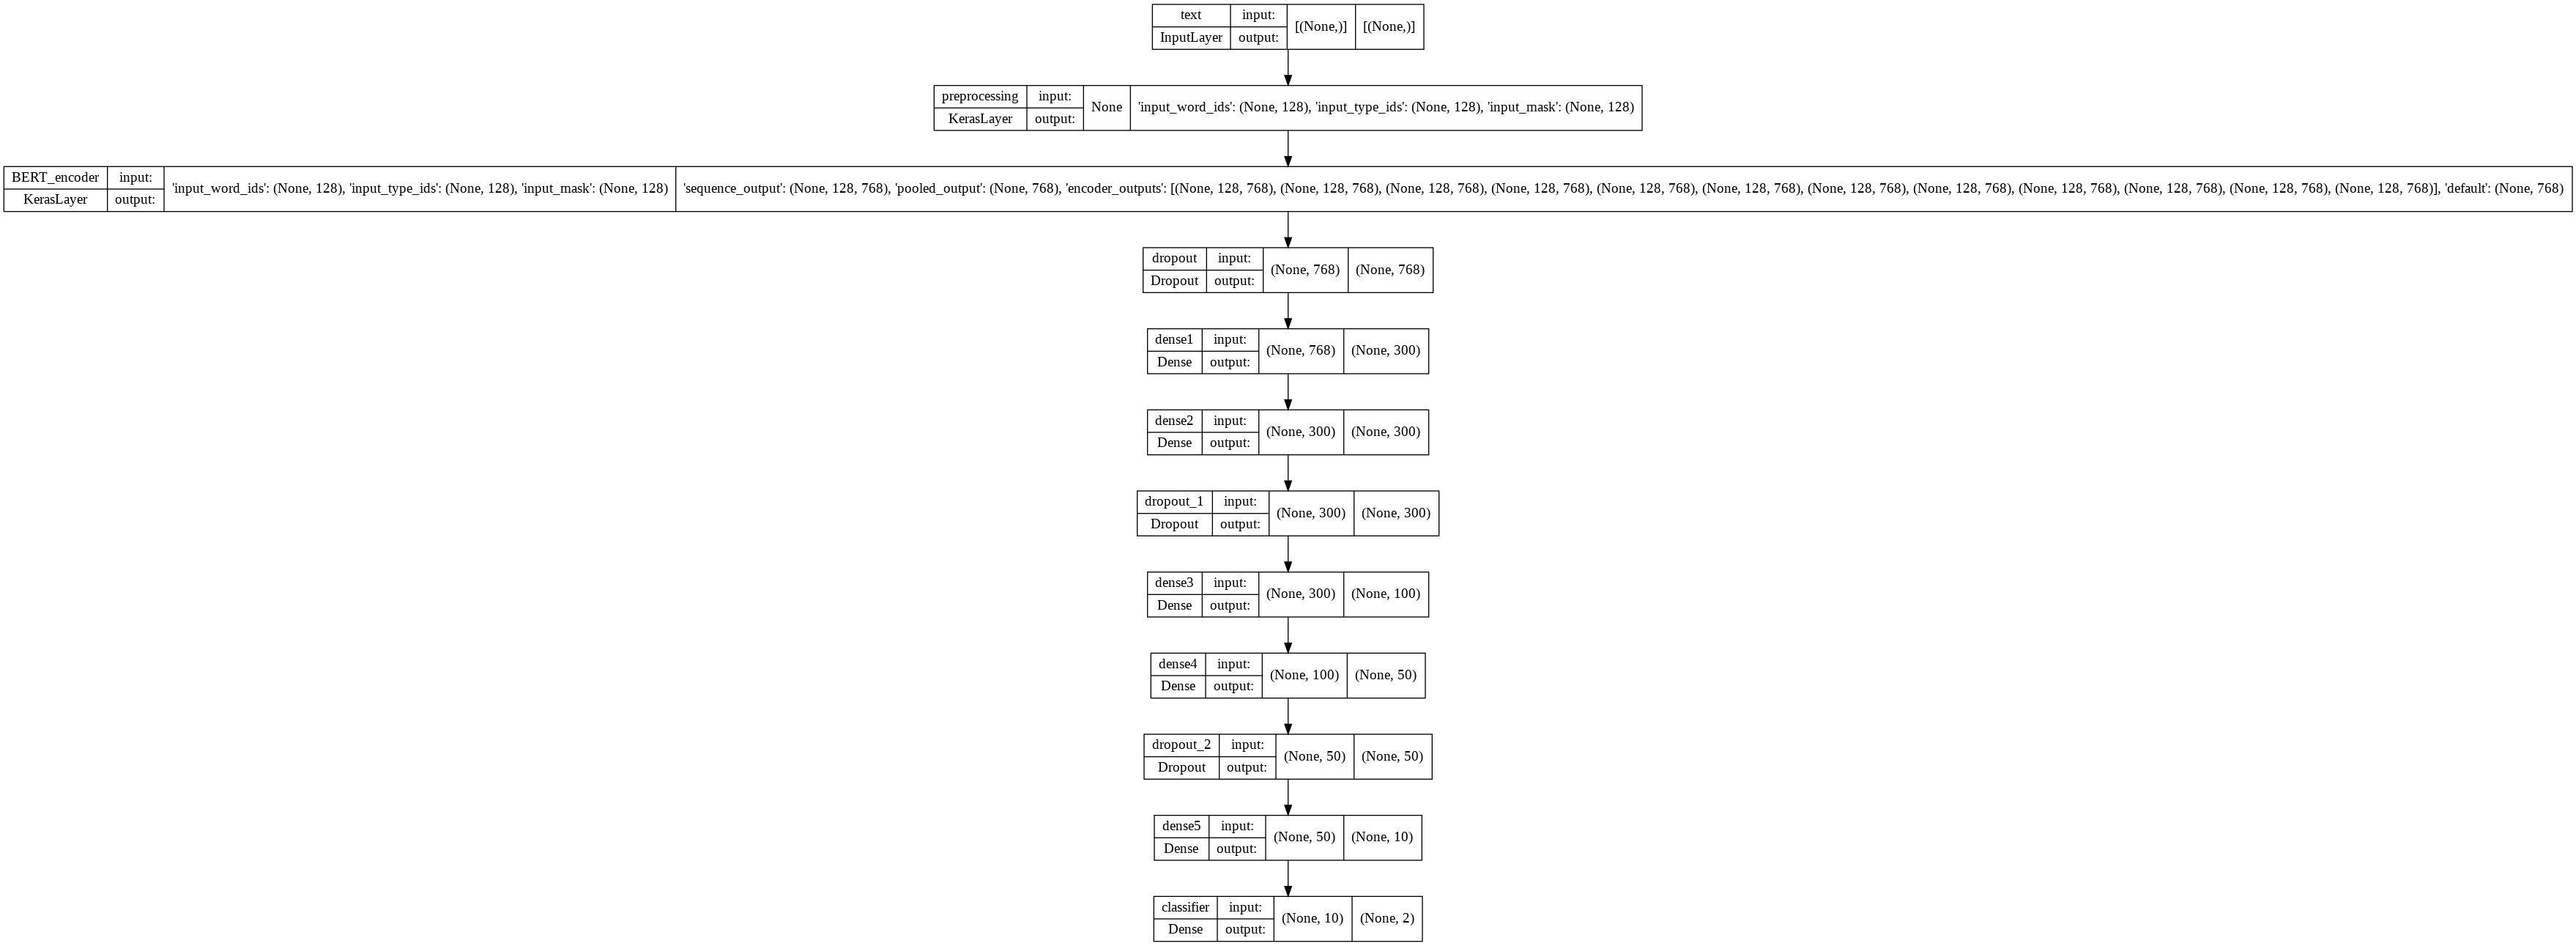

In [ ]:
# tf.keras.utils.plot_model(model, to_file='drive/MyDrive/ANNSSM/codes/BERT-RDM/BERT_model.png', show_shapes=True)
tf.keras.utils.plot_model(model, to_file='drive/MyDrive/CMP/BERT-RDM/BERT_model.png', show_shapes=True)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    epochs=5,
    batch_size = 64,
    callbacks=[
      tf.keras.callbacks.EarlyStopping(
          monitor='val_loss',
          patience=3,
          restore_best_weights=True
      )
  ]
)

Epoch 1/5
929/929 [==============================] - 824s 866ms/step - loss: 0.4316 - accuracy: 0.7967 - val_loss: 0.4047 - val_accuracy: 0.8099
Epoch 2/5
929/929 [==============================] - 805s 866ms/step - loss: 0.3444 - accuracy: 0.8555 - val_loss: 0.3239 - val_accuracy: 0.8640
Epoch 3/5
929/929 [==============================] - 803s 865ms/step - loss: 0.3306 - accuracy: 0.8623 - val_loss: 0.3124 - val_accuracy: 0.8698
Epoch 4/5
929/929 [==============================] - 803s 865ms/step - loss: 0.3267 - accuracy: 0.8633 - val_loss: 0.2867 - val_accuracy: 0.8803
Epoch 5/5
929/929 [==============================] - 805s 866ms/step - loss: 0.3199 - accuracy: 0.8658 - val_loss: 0.2717 - val_accuracy: 0.8885


Saving the model

In [ ]:
model.save("drive/MyDrive/CMP/BERT-RDM/BERT_model")

## Predicted Probabilities on full dataset

In [ ]:
from sklearn import metrics

full_dataset_predictions = model.predict(np.array(elp_df['string']))

#### Classification results

In [ ]:
print(metrics.classification_report(elp_df['label'].to_numpy(),  np.argmax(full_dataset_predictions, axis=1), digits=4))

              precision    recall  f1-score   support

           0     0.8875    0.9121    0.8996     40339
           1     0.8921    0.8628    0.8772     33978

    accuracy                         0.8895     74317
   macro avg     0.8898    0.8874    0.8884     74317
weighted avg     0.8896    0.8895    0.8894     74317



In [ ]:
acc_score = (metrics.accuracy_score(elp_df['label'].to_numpy(),  np.argmax(full_dataset_predictions, axis=1)))
acc_score

0.8895407511067455

#### Confusion Matrix

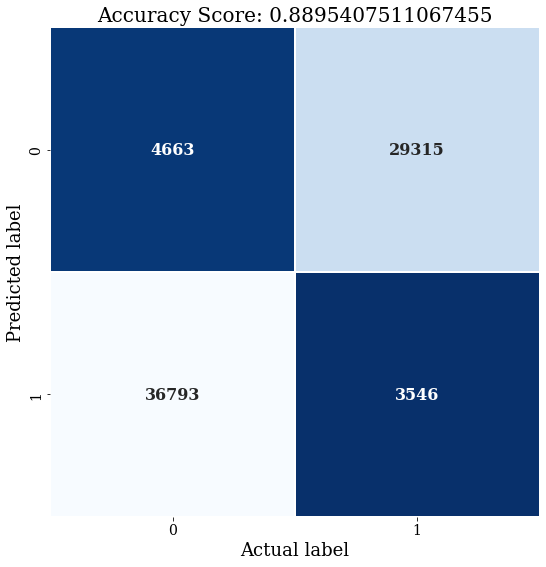

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['pdf.use14corefonts'] = True

cm = metrics.confusion_matrix(np.argmax(np.array(list(elp_df['code'])), axis=1), np.argmax(full_dataset_predictions, axis=1))
plt.figure(figsize=(9,9))
hm = sns.heatmap(cm, annot=True, fmt=".0f", cbar=False, linewidths=.5, square = True, cmap = 'Blues_r',
            annot_kws={
                'fontsize': 16,
                'fontweight': 'bold'
            });
hm.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 14)
hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 14)
hm.set_xlabel('Actual label', fontsize=18);
hm.set_ylabel('Predicted label', fontsize=18);
all_sample_title = 'Accuracy Score: {0}'.format(acc_score)
plt.title(all_sample_title, size = 20);
plt.savefig(root+'BERT_ACC.pdf')

#### Pridected Probabilites for each words category and non-words

In [ ]:
elp_df['word_prob']=full_dataset_predictions[:,1]
elp_df['nword_prob']=full_dataset_predictions[:,0]

In [ ]:
elp_df.groupby(['category']).agg({'word_prob': ['mean', 'std', 'count', 'max', 'min'], 'nword_prob': ['mean', 'std', 'count', 'max', 'min']})

word_prob                                      nword_prob            \
              mean       std  count       max       min       mean       std   
category                                                                       
HF        0.877685  0.173499  14333  0.999697  0.013784   0.122315  0.173499   
LF        0.729572  0.258113  19645  0.999600  0.002500   0.270428  0.258113   
NW        0.151125  0.207281  40339  0.997484  0.000177   0.848875  0.207281   

                                     
          count       max       min  
category                             
HF        14333  0.986216  0.000303  
LF        19645  0.997500  0.000400  
NW        40339  0.999823  0.002516

## Save Predicted Probabilities of full dataset

In [ ]:
word_df_to_save = elp_df.drop(['represention', 'code'], axis=1)

In [ ]:
word_df_to_save

,string,freq,label,zipf,category,word_prob,nword_prob
35647,tantrums,436,1,2.689774,LF,0.832770,0.167230
1195,amounts,13100,1,3.551906,HF,0.997451,0.002549
22509,donsoon,0,0,0.000000,NW,0.040383,0.959617
15126,goblat,0,0,0.000000,NW,0.018225,0.981775
30216,gotor,0,0,0.000000,NW,0.273178,0.726821
...,...,...,...,...,...,...,...
31119,scabby,51,1,2.570588,LF,0.792912,0.207088
17883,Indiaka,0,0,0.000000,NW,0.154654,0.845346
34334,stoic,165,1,2.634257,LF,0.652427,0.347573
9312,deprime,0,0,0.000000,NW,0.383753,0.616247


In [ ]:
word_df_to_save.to_csv(root+"/BERT.csv", header=0, index=False)